# Lasagne Tutorial

_This tutorial assumes basic knowledge of Theano.  [Here](http://nbviewer.ipython.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb) is a Theano tutorial if you need to get up to speed._

Theano is increadibly useful for compiling and automatically differentiating symbolic expressions transparently on a CPU or GPU.  While it is designed with the application of large neural networks in mind, it has relatively little functionality towards that end.  [Lasagne](https://github.com/benanne/Lasagne/) is a Python module built on top of Theano which provides useful classes and functions which make building neural network models simple.  It has been designed to extend Theano's functionality, so it generally follows Theano's conventions and methods typically accept and return Theano expressions.  In this way, it makes constructing commonly used network structures easy but also allows for arbitrary/unconventional models.  It's also meant to provide a reference implementation which is highly optimized.  Lasagne is developed by a diverse group of researchers with different applications in mind, which ensures that it is both generic and coherent.

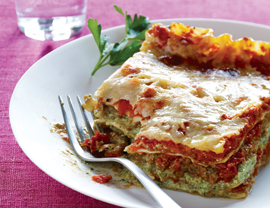

In [1]:
import theano
import theano.tensor as T
import lasagne
import numpy as np
import sklearn.datasets
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
IPython.display.Image("http://static-vegetariantimes.s3.amazonaws.com/wp-content/uploads/2009/03/10851medium.jpg")

## Toy example

As a toy example to demonstrate functionality, we'll train a standard multi-layer perceptron on a simple synthetic two-dimensional four-class dataset.

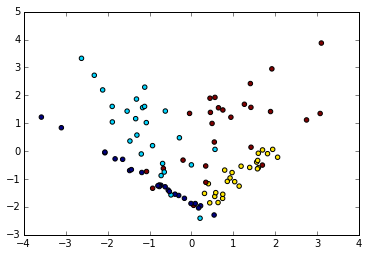

In [2]:
# Generate synthetic data
N_CLASSES = 4
X, y = sklearn.datasets.make_classification(
    n_features=2, n_redundant=0,
    n_classes=N_CLASSES, n_clusters_per_class=1)
# Convert to theano floatX
X = X.astype(theano.config.floatX)
# Labels should be ints
y = y.astype('int32')
# Make a scatter plot where color encodes class
plt.scatter(X[:, 0], X[:, 1], c=y)

### Ingredients: `layers`

What is lasagne made out of?  A stack of layers of noodles, sauce, cheeses, etc.  Just like making lasagne, constructing a network in `lasagne` typically involves stacking `Layer` subclass instances.  Much of Lasagne's functionality centers around subclasses of the `Layer` class.  A typical `Layer` subclass is an implementation of some kind of commonly used neural network layer, and contains the layer's parameters as well as methods for computing the Theano expression of the network given a Theano tensor variable used as input.  Most `Layer`s are initialized with a pointer to their input layer.  The output of the network can be generated using the `lasagne.layers.get_output` method, which recursively computes a symbolic Theano expression for the output of all layers given an input.  

#### `InputLayer`

The class `InputLayer` is a special layer type which stops the recurision and allows the user to input actual data into the network.  It also, for convenience, instantiates a Theano tensor variable `input_var` of the right type given the shape you provide it.  The `input_var` variable is used by default to compute the symbolic Theano expression of the network (see below).

In [3]:
# First, construct an input layer.
# The shape parameter defines the expected input shape, which is just the shape of our data matrix X.
l_in = lasagne.layers.InputLayer(shape=X.shape)

#### `DenseLayer`

The `DenseLayer` is the basic building block of the neural network: It computes a linear mix of the input $x$ using a weight matrix $W$ and a bias vector $b$, and then applies a nonlinearity $\sigma$, yielding $\sigma(Wx + b)$.  The `DenseLayer` class keeps track of the parameters and how to use them to compute this expression.

In [4]:
# We'll create a network with two dense layers: A tanh hidden layer and a softmax output layer.
l_hidden = lasagne.layers.DenseLayer(
    # The first argument is the input layer
    l_in,
    # This defines the layer's output dimensionality
    num_units=10,
    # Various nonlinearities are available
    nonlinearity=lasagne.nonlinearities.tanh)
# For our output layer, we'll use a dense layer with a softmax nonlinearity.
l_output = lasagne.layers.DenseLayer(
    l_hidden, num_units=N_CLASSES, nonlinearity=lasagne.nonlinearities.softmax)

#### `get_output`

To actually compute the Theano expression of a stack of `Layer` subclass instances, use the `get_output` function from `lasagne.layers`.  As mentioned above, by default `get_output` will compute the output given the input variable `input_var` of the `InputLayer` at the base of the network.  You can also pass a Theano symbolic variable to get the output of the network with respect to that variable instead.

In [5]:
net_output = lasagne.layers.get_output(l_output)

### Tasting: `objectives`

When making a lasagna, you need a way to decide when it's ready to eat.  A talented lasagne cook can do this by tasting it.  Machine learning practitioners use objective functions to decide when their neural network is ready to use, i.e. has been successfuly trained.  `lasagne`'s `objectives` submodule provides convenient functions for computing a symbolic Theano expression for an objective function.  Usually this involves comparing the output of a network to a true value.

In [6]:
# As a loss function, we'll use Lasagne's categorical_crossentropy function.
# This allows for the network output to be class probabilities,
# but the target output to be integers denoting the class.
true_output = T.ivector('true_output')
loss = T.mean(lasagne.objectives.categorical_crossentropy(net_output, true_output))

### Baking: `updates`

After assembling a lasagna, you need to bake it until it's ready to eat.  Getting a neural network ready to use is done by optimizing its parameters with respect to the objective.  Lasagne crucially provides functionality for constructing updates to optimize the network's parameters according to some objective (i.e. train it).  This makes it easy to, for example, train a network with stochastic gradient descent (or something more fancy like AdaGrad).  Computing the updates typically involves collecting the network's parameters using `get_all_params` then using a function in `lasagne.updates`.  The resulting updates list can then be fed into a `theano.function` to train the network.

In [7]:
# Retrieving all parameters of the network is done using get_all_params,
# which recursively collects the parameters of all layers connected to the provided layer.
all_params = lasagne.layers.get_all_params(l_output)
# Now, we'll generate updates using Lasagne's SGD function
updates = lasagne.updates.sgd(loss, all_params, learning_rate=1)
# Finally, we can compile Theano functions for training and computing the output.
# Note that because loss depends on the input variable of our input layer,
# we need to retrieve it and tell Theano to use it.
train = theano.function([l_in.input_var, true_output], loss, updates=updates)
get_output = theano.function([l_in.input_var], net_output)

In [8]:
# Train (bake?) for 100 epochs
for n in xrange(100):
    train(X, y)

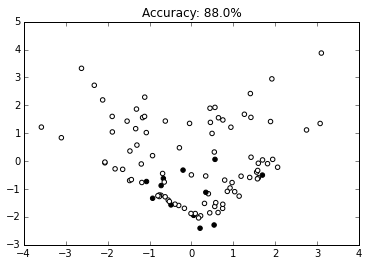

In [9]:
# Compute the predicted label of the training data.
# The argmax converts the class probability output to class label
y_predicted = np.argmax(get_output(X), axis=1)
# Plot incorrectly classified points as black dots
plt.scatter(X[:, 0], X[:, 1], c=(y != y_predicted), cmap=plt.cm.gray_r)
# Compute and display the accuracy
plt.title("Accuracy: {}%".format(100*np.mean(y == y_predicted)))

## Real-world example (MNIST ConvNet)

The above example illustrates the simplest possible usage of `lasagne`.  Fortunately, it's also useful for real-world problems.  Here, we'll train a convolutional network to classify MNIST digits.  This example is based on the [`mnist.py`](https://github.com/benanne/Lasagne/blob/master/examples/mnist.py) script included with Lasagne.

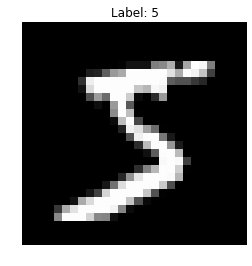

In [10]:
# We'll use the load_data function from the mnist.py example
from mnist import load_dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()
# Create a dataset dictionary for convenience
dataset = {
    'train': {'X': X_train, 'y': y_train},
    'valid': {'X': X_valid, 'y': y_valid}}
# Plot an example digit with its label
plt.imshow(dataset['train']['X'][0][0], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(dataset['train']['y'][0]))
plt.gca().set_axis_off()

### ConvNet Input

In `lasagne`, the convention for a 2D convolutional network is that the data's shape throughout the network is `(n_examples, n_channels, width, height)`.  Since MNIST digits has a single channel (they're grayscale images), `n_channels = 1` for the input layer; if we were dealing with RGB images we'd have `n_channels = 3`.  Within the network, `n_channels` is the number of filter kernels of each layer.

Conveniently, we can make the first dimension (the "number of example" dimension) variable.  This comes in handy when you pass your network training examples in minibatches, but want to evaluate the output on the entire validation or test set.  This is designated by setting the first entry of the shape passed to the `InputLayer` to `None`.

In [11]:
# We'll determine the input shape from the first example from the training set.
input_shape = dataset['train']['X'][0].shape
l_in = lasagne.layers.InputLayer(
    shape=(None, input_shape[0], input_shape[1], input_shape[2]))

### Convolutional layers

The basic 2D convolutional layer in Lasagne is `Conv2DLayer`.  This uses Theano's built-in convolution operation to convolve a collection 2D filter against the last two dimensions of its inputs.  Theano's convolution operation is smart enough to use a more efficient backend (e.g. `cudnn`) when possible and available.

#### Note on parameter initialization

The initialization used for each parameter in each layer can be a Numpy `ndarray`, a Theano shared variable, or an `Initializer` subclass from `lasagne.init`.  Many common initialization schemes are included in Lasagne for convenience.  For example, below we'll be initializing the convolutional layer weights using the approach proposed by He et. al. in ["Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"](http://arxiv.org/abs/1502.01852).  This approach initializes the weights by sampling a Gaussian distribution with zero mean and $\sigma = \sqrt{\frac{2}{n\_in}}$, where $n\_in$ is the number of inputs to the layer.

In [12]:
# Create the first convolutional layer
l_conv1 = lasagne.layers.Conv2DLayer(
    l_in,
    # Here, we set the number of filters and their size.
    num_filters=32, filter_size=(5, 5),
    # lasagne.nonlinearities.rectify is the common ReLU nonlinearity
    nonlinearity=lasagne.nonlinearities.rectify,
    # Use He et. al.'s initialization
    W=lasagne.init.HeNormal(gain='relu'))
# Other arguments: Convolution type (full, same, or valid) and stride

### Pooling layers

2D max pooling is straightforward: Use the `MaxPool2DLayer`.

In [13]:
# Here, we do 2x2 max pooling.  The max pooling layer also supports striding
l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))

In [14]:
# The second convolution/pooling pair is the same as above.
l_conv2 = lasagne.layers.Conv2DLayer(
    l_pool1, num_filters=32, filter_size=(5, 5),
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))
l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))

### Dense layers

We'll be using a single hidden layer and a dense output layer with dropout in between.  As is the convention in convnets, the hidden layer will use a ReLU nonlinearity.

In [15]:
l_hidden1 = lasagne.layers.DenseLayer(
    l_pool2, num_units=256, 
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

### Dropout

Dropout in Lasagne is implemented as a `Layer` subclass.  By placing a `DropoutLayer` between layers, the connections between the two layers will randomly be dropped.  As we'll see later, setting `get_output` or `get_loss`'s keyword argument `deterministic` to `True` will make the `DropoutLayer` act as a simple pass-through, which is useful when computing the output of the network after training.

In [16]:
# p is the dropout probability
l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)

In [17]:
l_output = lasagne.layers.DenseLayer(
    l_hidden1_dropout,
    # The number of units in the softmas output layer is the number of classes.
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

### Objectives, updates, and training

This part of the code will look very similar to above - we'll define an objective, compute some updates, use the updates to compile Theano functions, then use the functions to train the network and compute its output given some input.  Since this problem is a little harder than our toy example, we'll use ADADELTA, a fancier stochastic optimization technique, described in [ADADELTA: An Adaptive Learning Rate Method](http://arxiv.org/abs/1212.5701).  There's plenty of others to choose from in `lasagne.updates`.

In [18]:
true_output = T.ivector('true_output')
loss = T.mean(lasagne.objectives.categorical_crossentropy(net_output, true_output))

# As mentioned above, when using dropout we should define different losses:
# One for training, one for evaluation.  The training loss should apply dropout,
# while the evaluation loss shouldn't.  This is controlled by setting get_output's deterministic kwarg.
loss_train = T.mean(lasagne.objectives.categorical_accuracy(
        lasagne.layers.get_output(l_output, deterministic=False), true_output))
loss_eval = T.mean(lasagne.objectives.categorical_accuracy(
        lasagne.layers.get_output(l_output, deterministic=True), true_output))

all_params = lasagne.layers.get_all_params(l_output)
# Use ADADELTA for updates
updates = lasagne.updates.adadelta(loss_train, all_params)
train = theano.function([l_in.input_var, true_output], loss_train, updates=updates)

# This is the function we'll use to compute the network's output given an input
# (e.g., for computing accuracy).  Again, we don't want to apply dropout here
# so we set the deterministic kwarg to True.
get_output = theano.function([l_in.input_var],
                             lasagne.layers.get_output(l_output, deterministic=True))

In [19]:
# Now, let's train it!  We'll chop the training data into mini-batches,
# and compute the validation accuracy every epoch.
BATCH_SIZE = 100
N_EPOCHS = 10
# Keep track of which batch we're training with
batch_idx = 0
# Keep track of which epoch we're on
epoch = 0
while epoch < N_EPOCHS:
    # Extract the training data/label batch and update the parameters with it
    train(dataset['train']['X'][batch_idx:batch_idx + BATCH_SIZE],
          dataset['train']['y'][batch_idx:batch_idx + BATCH_SIZE])
    batch_idx += BATCH_SIZE
    # Once we've trained on the entire training set...
    if batch_idx >= dataset['train']['X'].shape[0]:
        # Reset the batch index
        batch_idx = 0
        # Update the number of epochs trained
        epoch += 1
        # Compute the network's output on the validation data
        val_output = get_output(dataset['valid']['X'])
        # The predicted class is just the index of the largest probability in the output
        val_predictions = np.argmax(val_output, axis=1)
        # The accuracy is the average number of correct predictions
        accuracy = np.mean(val_predictions == dataset['valid']['y'])
        print("Epoch {} validation accuracy: {}".format(epoch, accuracy))

Epoch 1 validation accuracy: 0.9818
Epoch 2 validation accuracy: 0.987
Epoch 3 validation accuracy: 0.9894
Epoch 4 validation accuracy: 0.9903
Epoch 5 validation accuracy: 0.9901
Epoch 6 validation accuracy: 0.9895
Epoch 7 validation accuracy: 0.9915
Epoch 8 validation accuracy: 0.9918
Epoch 9 validation accuracy: 0.9929
Epoch 10 validation accuracy: 0.9917


In [20]:
# Hmm... maybe MNIST is a toy example too.

## Recurrent Networks

Lasagne incudes classes for a "vanilla" (densely connected) recurrent layer, a recurrent layer with arbitrary input-to-hidden and hidden-to-hidden connections, an LSTM layer, and a GRU layer.  The usage is a little different due to the fact that the network expects batches time sequences as input; here we will demonstrate usage on a common long-term memory benchmark.

### The "add" task

In "[Long short-term memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)", the paper which proposed the LSTM unit, a handful of tasks are proposed which are meant to test a model's ability to handle long-term dependencies.  Here, we will use the "add" task, in which a two-dimensional time series is presented to the model where one dimension is sampled uniformly from $[0, 1]$ and the other is all zeros except at two samples where it is 1.  The goal for each time series is to output the sum of the values in the first dimension at the indices where the second dimension is 1.  For example, the target for the following

    | 0.5 | 0.7 | 0.3 | 0.1 | 0.2 | ... | 0.5 | 0.9 | ... | 0.8 | 0.2 |
    |  0  |  0  |  1  |  0  |  0  |     |  0  |  1  |     |  0  |  0  |

would be 0.3 + .9 = 1.2.  The `recurrent.py` example includes a function `gen_data` which generates data for this task; we'll use this function here.

In [21]:
from recurrent import gen_data

### Recurrent layer shape conventions

Because recurrent layers are used in tasks where the sequential nature of the input data matters, an additional dimension is needed beyond the `(batch_size, n_features_1, n_features_2, ...)` shape expected by convolutional and dense layers.  We could, of course, use the first dimension as the "number of sequence steps" dimension, but that would mean that we could not present minibatches of sequences to the network, which would slow down training and probably hurt convergence.  So, the convention used in `lasagne` is that sequential data is presented in the shape `(batch_size, n_time_steps, n_features_1, n_features_2, ...)`.

#### Masks
Because not all sequences in each minibatch will always have the same length, all recurrent layers in `lasagne` accept a separate mask input which has shape `(batch_size, n_time_steps)`, which is populated such that `mask[i, j] = 1` when `j <= (length of sequence i)` and `mask[i, j] = 0` when `j > (length of sequence i)`.  When no mask is provided, it is assumed that all sequences in the minibatch are of length `n_time_steps`.

#### Variable number of time steps

Finally, as is true of the first (`batch_size`) dimension, the `n_time_steps` dimension can be set to `None`, which means that it can vary from batch to batch.  This means that the network can take in minibatches which have an arbitrary number of sequences which are of arbitrary length - very convenient!

In [22]:
# By setting the first and second dimensions to None, we allow
# arbitrary minibatch sizes with arbitrary sequence lengths.
# The number of feature dimensions is 2, as described above.
l_in = lasagne.layers.InputLayer(shape=(None, None, 2))
# This input will be used to provide the network with masks.
# Masks are expected to be matrices of shape (n_batch, n_time_steps);
# both of these dimensions are variable for us so we will use
# an input shape of (None, None)
l_mask = lasagne.layers.InputLayer(shape=(None, None))

### Recurrent layers

The interface for `RecurrentLayer`, `GRULayer`, and `LSTMLayer` are all pretty similar.  Here, we will be using the `LSTMLayer`, which has the most construction arguments; usage of the other layers will generally be a little simpler!

#### Parameter initialization

In order to cut down on the number of constructor arguments and make changing initialization schemes more convenient, the `GRULayer` and `LSTMLayer` utilize the `Gate` class, which is essentially just a container for parameter initializers.  The `LSTMLayer` initializer accepts four `Gate` instances - one for the input gate, one for the forget gate, one for the cell, and one for the output gate.  Here, we will demonstrate how to change the weight initialization for all gates to use orthogonal initialization, which (anecdotally) can facilitate learning in RNNs.  Note that the cell "gate" doesn't use a weight matrix for a cell connection (that wouldn't make sense), and it uses a different nonlinearity.

In [23]:
# All gates have initializers for the input-to-gate and hidden state-to-gate
# weight matrices, the cell-to-gate weight vector, the bias vector, and the nonlinearity.
# The convention is that gates use the standard sigmoid nonlinearity,
# which is the default for the Gate class.
gate_parameters = lasagne.layers.recurrent.Gate(
    W_in=lasagne.init.Orthogonal(), W_hid=lasagne.init.Orthogonal(),
    b=lasagne.init.Constant(0.))

cell_parameters = lasagne.layers.recurrent.Gate(
    W_in=lasagne.init.Orthogonal(), W_hid=lasagne.init.Orthogonal(),
    # Setting W_cell to None denotes that no cell connection will be used.
    W_cell=None, b=lasagne.init.Constant(0.),
    # By convention, the cell nonlinearity is tanh in an LSTM.
    nonlinearity=lasagne.nonlinearities.tanh)

### `LSTMLayer` options

Apart from taking in the layer's input connection, the number of units, and `Gate` instances for parameter initialization, the `LSTMLayer` has a variety of other constructor arguments which determine the behavior of the layer.  As mentioned above, many of these arguments are shared by the other recurrent layers.

#### Cell and hidden state initialization

The layer's state at the beginning of the sequence can be set by passing initializers to the `cell_init` and `hid_init` arguments; by default, they are initialized to zeros.  Somtimes these initial values are learned as parameters of the network, sometimes they aren't; you can decide whether you want to include them as parameters to be learned by setting the `learn_init` argument to `True` or `False`.

#### "Peephole" connections

A common augmentation to the originally propsed LSTM architecture is to include connections from the cell state to the gates.  Some people use this, some people don't, you can decide which you want by setting the `peepholes` argument to `True` or `False`.

#### Truncating the number of backpropagation steps

The de facto method for training recurrent networks is backpropagation through time, which simply unrolls the network across timesteps and treats it as a network which is repeated for each time step.  This can result in an incredibly "deep" and computationally expensive network, so it's common practice to truncate the number of unrolled sequence steps.  This can be controlled with the `gradient_steps` argument; when it's `-1` (the default), this means "don't truncate".

#### Clipping gradients

A common method for mitigating the exponentially growing gradients commonly found when "unrolling" recurrent networks through time and backpropagating is to simply preventing them from being larger than a pre-set value.  In recurrent layers, this can be achieved by passing in a float (rather than `False` to `grad_clipping`.

#### Unrolling recursion

`theano`'s underlying method for recursion, `scan`, isn't terribly efficient.  Some speedup can be achieved (with some additional memory usage) by explicitly using a `for` loop in Python instead of `scan`.  `lasagne` has a utility function for this, `utils.unroll_scan`, which can be swapped in for `theano.scan` by setting `unroll_scan=True`.  Unfortunately, this currently requires that the `n_time_steps` dimension be known beforehand, so we will use the default of `unroll_scan=False`.

#### Precomputing input dot products

Some of the dot products computed in recurrent layers are non-recursive, which means they can be computed ahead of time in one big dot product.  Since one big dot product is more efficient than lots of little dot products, `lasagne` does it by default.  However, it imposes an additional memory requirement, so if you're running out of memory, set `precompute_input` to `False`.

In [24]:
# Our LSTM will have 10 hidden/cell units
N_HIDDEN = 10
l_lstm = lasagne.layers.recurrent.LSTMLayer(
    l_in, N_HIDDEN,
    # We need to specify a separate input for masks
    mask_input=l_mask,
    # Here, we supply the gate parameters for each gate
    ingate=gate_parameters, forgetgate=gate_parameters,
    cell=cell_parameters, outgate=gate_parameters,
    # We'll learn the initialization and use gradient clipping
    learn_init=True, grad_clipping=100.)

### Bidirectional recurrence

It's often helpful to process sequences simultaneously forwards and backwards.  In `lasagne` this is achieved by using two recurrent layers in parallel, one of which has the `backwards` argument set to `True`.  When `backwards=True`, the sequence is processed in reverse, then the layer's output is reversed so that recurrent layer outputs always go from the start of the sequence to the finish.  The output of the forward and backward layers should then be combined using a `MergeLayer` of some kind - e.g. concatenating their output or summing it.

In [25]:
# The "backwards" layer is the same as the first,
# except that the backwards argument is set to True.
l_lstm_back = lasagne.layers.recurrent.LSTMLayer(
    l_in, N_HIDDEN, ingate=gate_parameters,
    mask_input=l_mask, forgetgate=gate_parameters,
    cell=cell_parameters, outgate=gate_parameters,
    learn_init=True, grad_clipping=100., backwards=True)
# We'll combine the forward and backward layer output by summing.
# Merge layers take in lists of layers to merge as input.
l_sum = lasagne.layers.ElemwiseSumLayer([l_lstm, l_lstm_back])

### Combining recurrent and feed-forward layers

As mentioned above, recurrent layers and feed-forward layers expect different input shapes.  The output of `l_sum` will be of shape `(n_batch, n_time_steps, N_HIDDEN)`.  If we fed this into a non-recurrent layer, it would think that the `n_time_steps` dimension was a "feature" dimension, when in fact it's a "sample" dimension.  That is, each index in the second dimension should be treated as a different sample, and a non-recurrent `lasagne` layer would instead treat them as different feature values, which would be incorrect.  Fortunately, the `ReshapeLayer` makes combining these conventions very convenient - we just combine the first and second dimension so that there are essentially `n_batch*n_time_steps` individual samples before using any non-recurrent layers, then (optionally) reshape the output back to the original shape.

Now, as mentioned above, we are using `None` in the `n_batch` and `n_time_steps` dimensions to allow for minibatches with an arbitrary number of sequences with an arbitrary number of timesteps.  We can't tell the `ReshapeLayer` exactly what to reshape to, but we can instead just tell it to squash all of the dimensions up to the last by using `-1` for the first dimension.  In order to reshape back to the original shape after using a non-recurrent layer, we can just retrieve the input layer's symbolic shape and use those symbolic variables in another `ReshapeLayer`, so that the correct values will be filled in at compile time.

Note that because we will only be using the output of the network at the end of the sequence, this could also be done using a `SliceLayer` (as in the [recurrent.py example](https://github.com/Lasagne/Lasagne/blob/master/examples/recurrent.py) included with `lasagne`) which is a bit more efficient.  In this tutorial, we'll do it with the `ReshapeLayer` for illustration.

In [26]:
# First, retrieve symbolic variables for the input shape
n_batch, n_time_steps, n_features = l_in.input_var.shape
# Now, squash the n_batch and n_time_steps dimensions
l_reshape = lasagne.layers.ReshapeLayer(l_sum, (-1, N_HIDDEN))
# Now, we can apply feed-forward layers as usual.
# We want the network to predict a single value, the sum, so we'll use a single unit.
l_dense = lasagne.layers.DenseLayer(
    l_reshape, num_units=1, nonlinearity=lasagne.nonlinearities.tanh)
# Now, the shape will be n_batch*n_timesteps, 1.  We can then reshape to
# n_batch, n_timesteps to get a single value for each timstep from each sequence
l_out = lasagne.layers.ReshapeLayer(l_dense, (n_batch, n_time_steps))

### Objectives, updates, and training

The rest of the code for training the recurrent network is quite similar to the feed-forward network with two key differences:  First, as mentioned above, a separate `theano` tensor variable `mask` is required to tell the network the length of each sequence in each minibatch, and second, the effectiveness of the network only really depends on the final time step output by the network, so we will simply slice away that value when computing a loss function.

In [27]:
# Symbolic variable for the target network output.
# It will be of shape n_batch, because there's only 1 target value per sequence.
target_values = T.vector('target_output')
# This matrix will tell the network the length of each sequences.
# The actual values will be supplied by the gen_data function.
mask = T.matrix('mask')

# lasagne.layers.get_output produces an expression for the output of the net
network_output = lasagne.layers.get_output(l_out)
# The value we care about is the final value produced for each sequence
# so we simply slice it out.
predicted_values = network_output[:, -1]
# Our cost will be mean-squared error
cost = T.mean((predicted_values - target_values)**2)
# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out)
# Compute adam updates for training
updates = lasagne.updates.adam(cost, all_params)
# Theano functions for training and computing cost
train = theano.function(
    [l_in.input_var, target_values, l_mask.input_var],
    cost, updates=updates)
compute_cost = theano.function(
    [l_in.input_var, target_values, l_mask.input_var], cost)

# We'll use this "validation set" to periodically check progress
X_val, y_val, mask_val = gen_data()

# We'll train the network with 10 epochs of 100 minibatches each
NUM_EPOCHS = 10
EPOCH_SIZE = 100
for epoch in range(NUM_EPOCHS):
    for _ in range(EPOCH_SIZE):
        X, y, m = gen_data()
        train(X, y, m)
    cost_val = compute_cost(X_val, y_val, mask_val)
    print("Epoch {} validation cost = {}".format(epoch + 1, cost_val))

/usr/local/lib/python2.7/site-packages/Theano-0.7.0-py2.7.egg/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/usr/local/lib/python2.7/site-packages/Theano-0.7.0-py2.7.egg/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


Epoch 1 validation cost = 0.168619907953
Epoch 2 validation cost = 0.155535056081
Epoch 3 validation cost = 0.0738346717391
Epoch 4 validation cost = 0.0452366159954
Epoch 5 validation cost = 0.0324324088071
Epoch 6 validation cost = 0.030376732186
Epoch 7 validation cost = 0.0178713113081
Epoch 8 validation cost = 0.0179671934104
Epoch 9 validation cost = 0.0144859958564
Epoch 10 validation cost = 0.0178673797724
